# Yolo on Fisheye
We have two methods to solve this fisheye detection problem: 

Method I:
1. Dewarp fisheye images
2. Run a yolo detector on it.
3. Map predicted boxes back to fisheye coordinates

Method II: 
1. Augment fisheye images a little bit for improving detections
2. Train yolo detector directly on fisheye frames
3. Map predicted boxes back to fisheye coordinates

## Imports

In [21]:
import torch
from torchvision.datasets import coco
import os
import numpy as np
import random
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont

In [22]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [23]:
DATA_PATH = '/media/abhitemb/DATA/Users/abhitemb/Documents/FishEye/TrainVal/Fisheye8K_all_including_train&test'
TRAIN_PATH = os.path.join(DATA_PATH, 'train', 'images')
TRAIN_ANNOT = os.path.join(DATA_PATH, 'train', 'train.json')
TEST_PATH = os.path.join(DATA_PATH, 'test', 'images')
TEST_ANNOT = os.path.join(DATA_PATH, 'test', 'test.json')

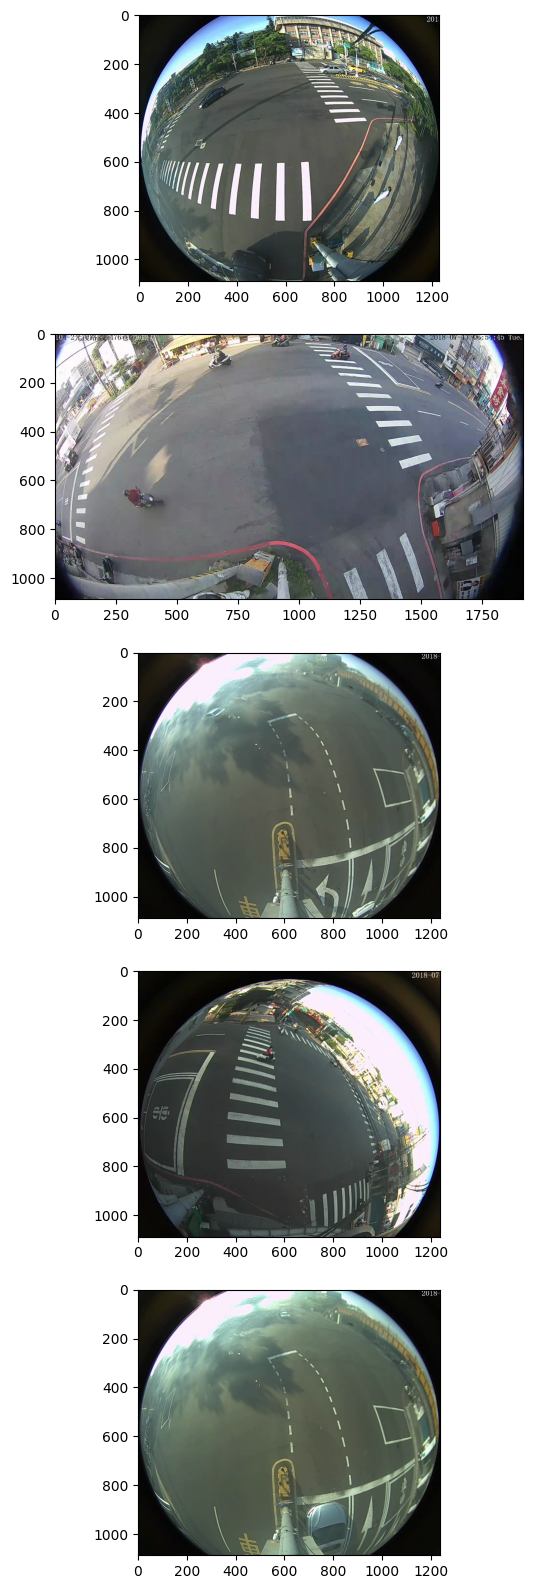

In [24]:
%matplotlib inline

imgs = os.listdir(TRAIN_PATH)
rand_imgs = np.random.choice(imgs, 5)

fig, ax = plt.subplots(5, 1, figsize=(10, 20))

for i, axes in enumerate(ax): 
    img = np.array(Image.open(os.path.join(TRAIN_PATH, rand_imgs[i])))
    axes.imshow(img)
    
plt.show()

In [25]:
train_dataset = coco.CocoDetection(TRAIN_PATH, annFile=TRAIN_ANNOT)
test_dataset = coco.CocoDetection(TEST_PATH, annFile=TEST_ANNOT)

loading annotations into memory...
Done (t=0.39s)
creating index...
index created!
loading annotations into memory...
Done (t=0.24s)
creating index...
index created!


In [26]:
# def draw_bounding_box(img, bounding_box, text, color):
#     x1, y1, w, h = bounding_box
#     draw = ImageDraw.Draw(img)
#     draw.rectangle(bounding_box, outline='red', width=3)
#     font = ImageFont.load_default()
    
#     text_size = draw.textsize(text, font=font)
#     text_origin = (x1, y1 - text_size[1] - 2)

#     draw.rectangle([text_origin, (text_origin[0] + text_size[0], text_origin[1] + text_size[1])], fill='red')
#     draw.text(text_origin, text, fill='white', font=font)

In [27]:
%matplotlib inline

def draw_bounding_box(img, bounding_box, label, color):
    draw = ImageDraw.Draw(img)
    font = ImageFont.load_default()
    label = str(label)
    
    x1, y1, w, h = bounding_box

    # draw rectangle
    draw.rectangle([x1, y1, x1 + w, y1 + h], outline=color, width=3)

    # label background
    # text_w, text_h = draw.textbbox(label, font=font, text=label)
    # # place above box, but not off image
    # ty = max(y1 - text_h - 2, 0)
    # draw.rectangle([x1, ty, x1 + text_w, ty + text_h], fill=color)

    # label text
    draw.text((x1, y1), label, fill='white', font=font)
    return img

[145, 343, 74, 108]
[684, 295, 55, 51]
[561, 676, 128, 150]
[803, 416, 66, 64]
[996, 682, 61, 56]
[1057, 743, 43, 39]
[380, 173, 62, 37]
[410, 139, 56, 30]
[934, 450, 70, 82]
[879, 379, 22, 34]
[882, 396, 30, 42]
[896, 411, 31, 41]
[340, 788, 79, 91]
[235, 795, 119, 137]
[343, 190, 28, 34]
[384, 198, 27, 40]
[365, 207, 30, 39]
[483, 199, 77, 44]
[472, 163, 62, 27]
[319, 167, 48, 42]
[322, 146, 23, 16]
[296, 172, 25, 25]
[744, 233, 42, 23]
[830, 248, 15, 16]
[820, 248, 13, 21]
[801, 245, 18, 20]
[785, 244, 19, 23]
[772, 245, 21, 24]
[760, 246, 23, 22]
[747, 244, 18, 26]
[824, 275, 18, 21]
[1090, 724, 42, 84]
[839, 342, 27, 38]
[1038, 590, 27, 39]
[1019, 566, 34, 44]
[1049, 613, 27, 37]
[784, 229, 17, 14]
[694, 214, 25, 25]
[729, 221, 20, 24]
[715, 218, 20, 26]
[275, 163, 20, 26]
[268, 159, 26, 20]
[256, 159, 18, 15]
[803, 236, 26, 27]
[370, 184, 21, 31]


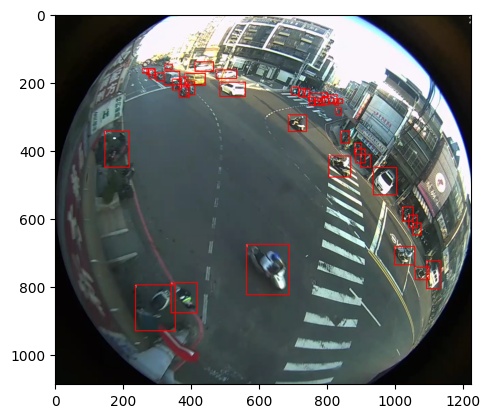

In [28]:
for img, lbls in train_dataset:
    new_img = None

    for lbl in lbls: 
        bounding_box = lbl['bbox']
        text = lbl['category_id']
        print(bounding_box)

        new_img = draw_bounding_box(img, bounding_box, text, 'red')
        
    plt.imshow(new_img)
    plt.show()

    break

In [29]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torch.optim import Adam, lr_scheduler
import torch.nn as nn
from tqdm import tqdm
from torch.utils.data import DataLoader
import gc
from torchvision.transforms import Compose, ToTensor

In [30]:
num_classes = 6
model1 = fasterrcnn_resnet50_fpn(pretrained=True)
input_features = model1.roi_heads.box_predictor.cls_score.in_features

/home/abhitemb/Dev/DL/aicitychallenge1/.venv/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/abhitemb/Dev/DL/aicitychallenge1/.venv/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [31]:
# Freezing roi layers & training rpn and backbone layers
for p in model1.backbone.parameters(): 
    p.requires_grad = True

for p in model1.roi_heads.parameters():
    p.requires_grad = False

for p in model1.rpn.parameters():
    p.requires_grad = True

In [32]:
train_params = [p for p in model1.parameters() if p.requires_grad]
optimizer = Adam(train_params, lr=5e-3)
lr_sched = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
EPOCHS = 10

In [33]:
train_dataset = coco.CocoDetection(TRAIN_PATH, annFile=TRAIN_ANNOT, transform=Compose([ToTensor()]))
test_dataset = coco.CocoDetection(TEST_PATH, annFile=TEST_ANNOT, transform=Compose([ToTensor()]))

loading annotations into memory...
Done (t=0.26s)
creating index...
index created!
loading annotations into memory...
Done (t=0.10s)
creating index...
index created!


In [34]:
def collate(batch):
    images, targets = list(zip(*batch))
    return images, targets

trainloader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
    collate_fn=collate
)

testloader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=4, 
    pin_memory=True,
    collate_fn=collate
)

In [35]:
def train_loop(model):
    for e in range(EPOCHS):
        model.train()
        with torch.set_grad_enabled(True):
            for img, lbl in tqdm(trainloader):

                print(type(img), img)
                print(type(lbl), lbl)
                
                # img = torch.Tensor(np.array(img)).to(device)
                # targets = [{k: v.to(device) for k, v in l.items()} for l in lbl]

                loss_values = model(img, targets)
                loss = sum(l for l in loss_values.values())

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                total_loss += loss.item()
            
            lr_sched.step()
            print(f'Epoch: {e} | Train loss: {total_loss / len(train_dataset):.4f}')

In [36]:
def test_loop(model):
    model.eval()
    predicts = []
    
    with torch.no_grad():
        for img, lbl in tqdm(testloader):
            imgs = [imag.to(device) for imag in img]
            y = model(imgs)

            for target, output in zip(lbl, y):
                image_id = target["image_id"].item() if isinstance(target, dict) else target[0]['image_id']
                boxes = output["boxes"].cpu().tolist()
                scores = output["scores"].cpu().tolist()
                labels = output["labels"].cpu().tolist()

                for box, score, label in zip(boxes, scores, labels):
                    if score < 0.05:  # skip low-confidence
                        continue
                    x1, y1, x2, y2 = box
                    width = x2 - x1
                    height = y2 - y1
                    predicts.append({
                        "image_id": image_id,
                        "category_id": label,
                        "bbox": [x1, y1, width, height],
                        "score": score
                    })
    return predicts

In [37]:
def clear_memory(model):
    gc.collect()
    del model
    torch.cuda.empty_cache()

In [38]:
clear_memory(model1)

In [39]:
model2 = fasterrcnn_resnet50_fpn(pretrained=True)
model2 = model2.to(device)

In [ ]:
predicts = test_loop(model2)

  0%|          | 0/85 [00:00<?, ?it/s]

In [ ]:
import json

with open('output.json', "w") as f:
    json.dump(predicts, f)
print(f"Saved {len(predicts)} predictions")

In [ ]:
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

coco_gt = COCO(TEST_ANNOT)
coco_dt = coco_gt.loadRes('output.json')
coco_eval = COCOeval(coco_gt, coco_dt, iouType="bbox")
coco_eval.evaluate()
coco_eval.accumulate()
coco_eval.summarize()